In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.design as frd
import fastreg.linear as frl
import fastreg.general as frg
%matplotlib inline

### Generate Data

In [2]:
st = np.random.RandomState(89320432)
N, K1, K2 = 1_000_000, 10, 100

In [3]:
df0 = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df0['y'] = 5 + 3*df0['x1'] + 2*df0['x2'] + st.randn(N)
df0['lEp'] = 0.6*df0['x1'] + 0.2*df0['x2']
df0['Ep'] = np.exp(df0['lEp'])
df0['p'] = np.random.poisson(df0['Ep'])
df0['p0'] = np.where(st.rand(N) < 0.2, 0, df0['p'])
df0.head()

,id1,id2,x1,x2,y,lEp,Ep,p,p0
0,4,99,-0.232286,-1.106499,4.721238,-0.360671,0.697208,0,0
1,8,98,0.457063,0.585081,9.168498,0.391254,1.478834,2,0
2,8,73,0.761536,-0.705039,6.487252,0.315914,1.371512,1,1
3,8,40,-0.251006,-0.884939,1.583604,-0.327591,0.720657,3,3
4,6,90,-1.211539,1.763510,6.438151,-0.374222,0.687824,1,0


In [4]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 5 + 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,4,91,-1.568084,-0.302746,0.198134,-0.538400,0.583682,0
1,8,34,2.149949,0.738744,15.280657,1.623718,5.071913,5
2,4,85,0.270684,1.181311,9.546037,0.831672,2.297157,5
3,4,21,-0.035878,-0.017614,3.982287,0.087950,1.091934,1
4,7,33,0.874663,-0.392154,7.437846,0.625367,1.868932,1


### Normal OLS

In [6]:
%time smf.ols('y ~ x1 + x2', data=df0).fit().params

CPU times: user 837 ms, sys: 619 ms, total: 1.46 s
Wall time: 346 ms


Intercept    4.999722
x1           2.999900
x2           2.000421
dtype: float64

In [7]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df0)

CPU times: user 139 ms, sys: 108 ms, total: 247 ms
Wall time: 79.4 ms


,coeff,stderr,low95,high95,pvalue
intercept,4.999722,0.001000,4.997763,5.001681,0.0
x1,2.999900,0.000999,2.997941,3.001858,0.0
x2,2.000421,0.000998,1.998465,2.002378,0.0


### Sparse OLS

In [78]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 1.14 s, sys: 237 ms, total: 1.38 s
Wall time: 1.1 s


,coeff,stderr,low95,high95,pvalue
intercept,5.008952,0.010476,4.988420,5.029484,0.0
x1,3.002147,0.001001,3.000185,3.004109,0.0
x2,1.999583,0.001000,1.997623,2.001543,0.0
id1=1,0.103040,0.004468,0.094283,0.111798,0.0
id1=2,0.208639,0.004472,0.199874,0.217405,0.0
...,...,...,...,...,...
id2=95,0.942001,0.014201,0.914168,0.969834,0.0
id2=96,0.940008,0.014171,0.912233,0.967782,0.0
id2=97,0.967684,0.014171,0.939909,0.995458,0.0
id2=98,0.978038,0.014231,0.950145,1.005930,0.0


In [79]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=('id1', 'id2'), data=df0)

CPU times: user 1.57 s, sys: 537 ms, total: 2.11 s
Wall time: 1.23 s


,coeff,stderr,low95,high95,pvalue
intercept,0.000992,0.000002,0.000988,0.000995,0.0
x1,2.999914,0.001006,2.997943,3.001886,0.0
x2,2.000430,0.000978,1.998514,2.002347,0.0


### Poisson

In [10]:
%time frg.poisson(y='p', x=['x1', 'x2'], data=df0, device='cuda', output='table')

  0: loss = 0.7366986274719238
  1: loss = 0.7317739129066467
  2: loss = 0.7317739129066467
CPU times: user 38.2 s, sys: 614 ms, total: 38.9 s
Wall time: 38.9 s


,coeff,stderr,low95,high95,pvalue
intercept,-0.025178,0.001080,-0.027296,-0.023061,0.0
x1,0.576103,0.000919,0.574302,0.577904,0.0
x2,0.216270,0.000918,0.214471,0.218070,0.0


In [14]:
%time table, beta, sigma = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, device='cuda')

  0: loss = 0.522212564945221
  1: loss = 0.5146617889404297
  2: loss = 0.514546275138855
CPU times: user 53.8 s, sys: 2.29 s, total: 56.1 s
Wall time: 54.6 s


In [15]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

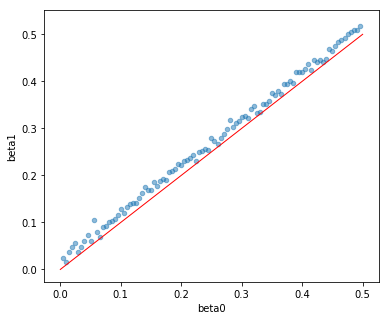

In [16]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);